In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [22]:
# Carga del archivo
data = pd.read_csv("./feature_engineering_work/dataset_feature_engineering.csv") 

# 1. Vista general
print(data.info())
print(data.describe())
print(data["is_fraud"].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 35 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   cc_num                           int64  
 1   merchant                         object 
 2   category                         object 
 3   amt                              float64
 4   first                            object 
 5   last                             object 
 6   gender                           object 
 7   street                           object 
 8   city                             object 
 9   state                            object 
 10  zip                              int64  
 11  lat                              float64
 12  long                             float64
 13  city_pop                         int64  
 14  job                              object 
 15  dob                              object 
 16  trans_num                        object 
 17  unix_tim

In [23]:
# 2. Variables categóricas más relevantes
cat_vars = ['merchant', 'category', 'first_time_at_merchant']
for var in cat_vars:
    print(f"\n{var}:\n", data[var].value_counts().head())



merchant:
 merchant
fraud_Kilback LLC    6262
fraud_Cormier LLC    5246
fraud_Schumm PLC     5195
fraud_Kuhn LLC       5031
fraud_Boyer PLC      4999
Name: count, dtype: int64

category:
 category
gas_transport    188029
grocery_pos      176191
home             175460
shopping_pos     166463
kids_pets        161727
Name: count, dtype: int64

first_time_at_merchant:
 first_time_at_merchant
False    1323066
True      529328
Name: count, dtype: int64


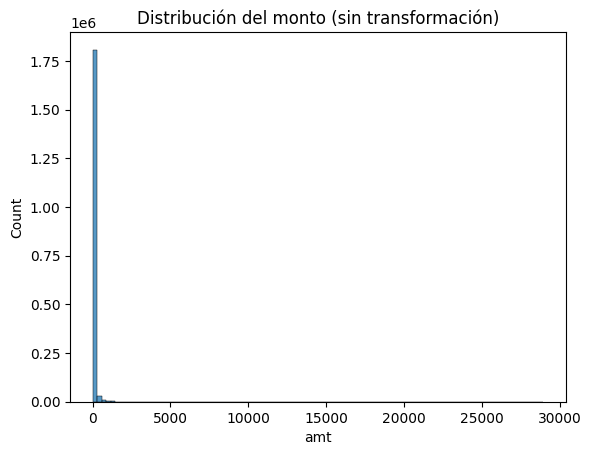

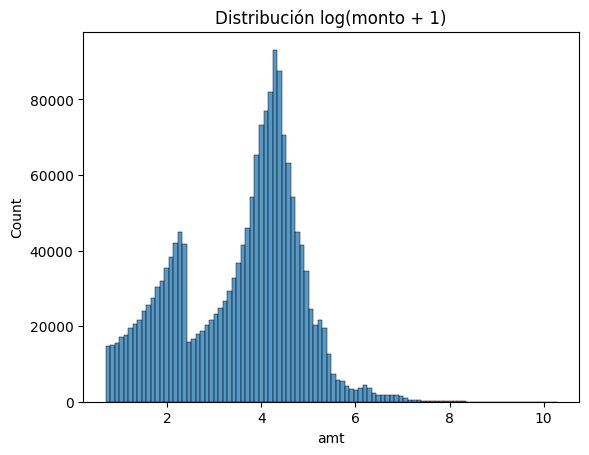

In [24]:
# 3. Distribuciones
sns.histplot(data['amt'], bins=100)
plt.title("Distribución del monto (sin transformación)")
plt.show()

# Log para corregir la asimetría
sns.histplot(np.log1p(data['amt']), bins=100)
plt.title("Distribución log(monto + 1)")
plt.show()


Debido a los datos obtenidos en la distribucion sin transformacion optamos por usar la transformacion logarítmica para la variable amt. Gracias a ello conseguimos:
- Reducir la asimetría de los valores grandes. 
- Hacer la distribución más cercana a una normal, lo que mejora el rendimiento del modelo. 
- Disminuir el impacto de valores atípicos (transacciones muy grandes).

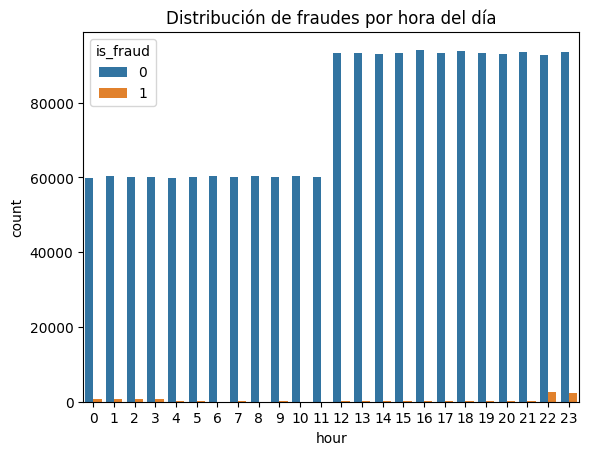

In [25]:
# 4. Fraude por hora
sns.countplot(x='hour', hue='is_fraud', data=data)
plt.title("Distribución de fraudes por hora del día")
plt.show()

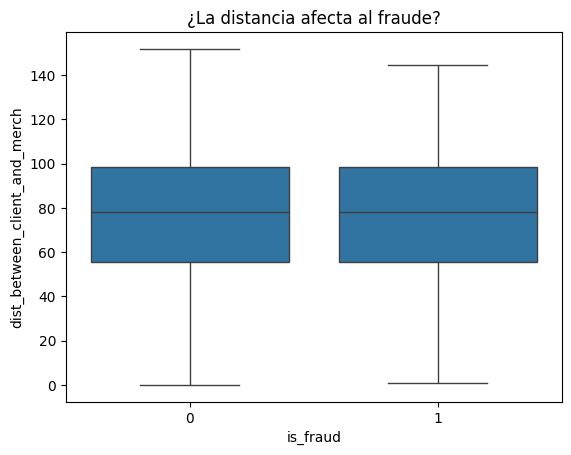

In [26]:
# 5. Distancia vs fraude
sns.boxplot(x='is_fraud', y='dist_between_client_and_merch', data=data)
plt.title("¿La distancia afecta al fraude?")
plt.show()

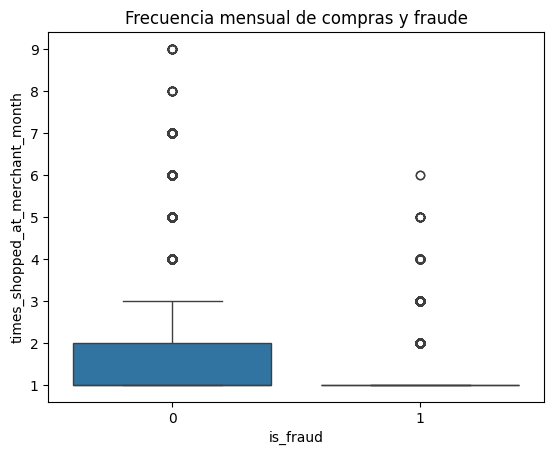

In [27]:
# 6. Frecuencia de compras en el comercio vs fraude
sns.boxplot(x='is_fraud', y='times_shopped_at_merchant_month', data=data)
plt.title("Frecuencia mensual de compras y fraude")
plt.show()

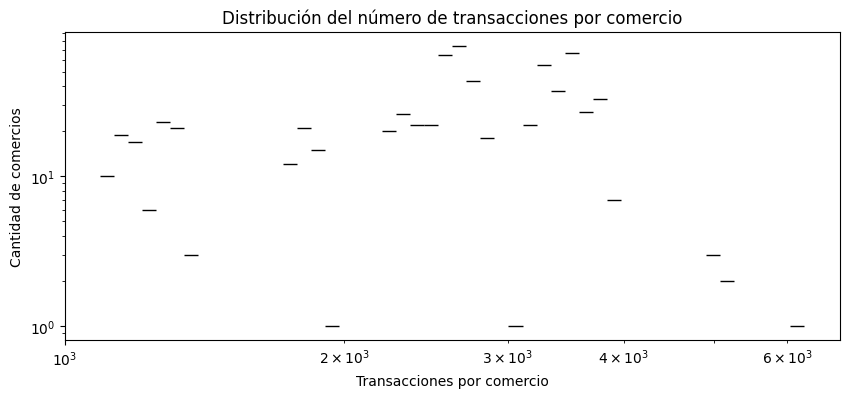

In [28]:
# 7. Umbral para detectar comercios con pocas transacciones
merchant_counts = data['merchant'].value_counts()
plt.figure(figsize=(10, 4))
sns.histplot(merchant_counts, bins=50, log_scale=(True, True))
plt.title("Distribución del número de transacciones por comercio")
plt.xlabel("Transacciones por comercio")
plt.ylabel("Cantidad de comercios")
plt.show()


In [29]:
# 7. Comercios con pocas transacciones
# Calcular el número de transacciones por comercio
merchant_counts = data['merchant'].value_counts()

# Calcular el percentil 16.5 como umbral para baja frecuencia
percentil_16 = np.percentile(merchant_counts, 16.5)

print(f"Umbral (percentil 16.5) para baja frecuencia: {percentil_16:.2f} transacciones")

# Identificar comercios de baja frecuencia
low_freq_merchants = merchant_counts[merchant_counts < percentil_16].index
low_freq_data = data[data['merchant'].isin(low_freq_merchants)].copy()

Umbral (percentil 16.5) para baja frecuencia: 1784.72 transacciones


In [30]:
# Cantidad del fraude ocurre en comercios de baja frecuencia
fraudes_baja_frecuencia = data[data['merchant'].isin(low_freq_merchants) & (data['is_fraud'] == 1)]
print("Fraudes en comercios de baja frecuencia:", len(fraudes_baja_frecuencia))

Fraudes en comercios de baja frecuencia: 694


In [31]:
# Cantidad que no son fraude en comercios de baja frecuencia
fraudes_baja_frecuencia = data[data['merchant'].isin(low_freq_merchants) & (data['is_fraud'] == 0)]
print("No son fraudes en comercios de baja frecuencia:", len(fraudes_baja_frecuencia))

No son fraudes en comercios de baja frecuencia: 149210


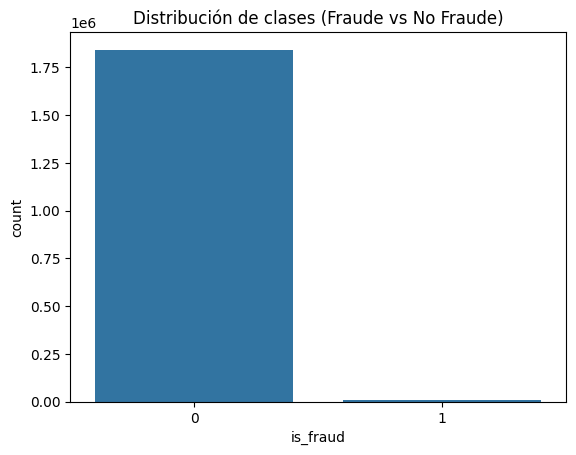

In [32]:
# Balanceo de clases
sns.countplot(x='is_fraud', data=data)
plt.title("Distribución de clases (Fraude vs No Fraude)")
plt.show()


## Ingeniería de Características enfocadas en el problema

✅ Objetivo de esta sección:
Crear variables derivadas que ayuden al modelo a capturar patrones de comportamiento que distingan entre transacciones legítimas y fraudulentas, especialmente en comercios de baja frecuencia.

In [33]:
# 1. ¿Es comercio de baja frecuencia?
# Agregar el conteo de transacciones por comercio a cada fila
low_freq_data['merchant_transaction_count'] = low_freq_data.groupby('merchant')['cc_num'].transform('count')

# Etiquetar si el comercio es de baja frecuencia
low_freq_data['is_low_freq_merchant'] = low_freq_data['merchant_transaction_count'] < percentil_16

# 2. Diferencia entre la media mensual del usuario vs esta transacción
low_freq_data['amt_vs_month_mean'] = low_freq_data['amt'] - (low_freq_data['amt_month'] / low_freq_data['times_shopped_at_merchant_month'].replace(0, np.nan))

# 3. Hora sospechosa (madrugada)
low_freq_data['is_night'] = low_freq_data['hour'].apply(lambda x: 1 if x < 6 else 0)

# 4. Distancia anómala (z-score por usuario)
low_freq_data['client_mean_dist'] = low_freq_data.groupby('cc_num')['dist_between_client_and_merch'].transform('mean')
low_freq_data['dist_zscore'] = (low_freq_data['dist_between_client_and_merch'] - low_freq_data['client_mean_dist']) / (
    low_freq_data.groupby('cc_num')['dist_between_client_and_merch'].transform('std').replace(0, np.nan)
)

# 5. Cambio brusco de gasto (z-score mensual)
low_freq_data['amt_zscore'] = (low_freq_data['amt'] - low_freq_data.groupby('cc_num')['amt'].transform('mean')) / (
    low_freq_data.groupby('cc_num')['amt'].transform('std').replace(0, np.nan)
)

### Division Train/Test Dataset

In [34]:
# Separar datos de test (diciembre 2020)
train_df = low_freq_data[~((low_freq_data['year'] == 2020) & (low_freq_data['trans_month'] == 12))]
test_df = low_freq_data[(low_freq_data['year'] == 2020) & (low_freq_data['trans_month'] == 12)]

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (138609, 42)
Test shape: (11295, 42)


In [ ]:


# Separar características y etiquetas
X_train = train_df.drop(columns=['is_fraud'])
y_train = train_df['is_fraud']

# Identificar columnas categóricas
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Codificar columnas categóricas con LabelEncoder
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    label_encoders[col] = le

# Imputar valores faltantes con la media (para variables numéricas)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Balanceo con SMOTE
n_class_0 = y_train.value_counts()[0]
sampling_strategy = 0.2

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_imputed, y_train)

# Verificación
print("Train shape (balanced):", X_train_balanced.shape)
print("Distribución de clases en el conjunto balanceado:")
print(pd.Series(y_train_balanced).value_counts())


Train shape (balanced): (165516, 41)
Distribución de clases en el conjunto balanceado:
is_fraud
0    137930
1     27586
Name: count, dtype: int64


### Entrenamiento del modelo Base (LightGBM)

### Metricas personalizadas

### custom_fp_ratio
🔎 Descripción:

Esta función calcula el ratio de falsos positivos por cada fraude detectado, definido como:
 
El objetivo es minimizar esta métrica, ya que un valor alto indica que por cada fraude real detectado, hay muchos falsos positivos.

In [36]:
def custom_fp_ratio(preds, train_data):
    y_true = train_data.get_label()
    preds_binary = (preds >= 0.5).astype(int)
    TP = np.sum((preds_binary == 1) & (y_true == 1))
    FP = np.sum((preds_binary == 1) & (y_true == 0))
    ratio = (TP + FP) / TP if TP != 0 else np.inf
    return 'fp_ratio', ratio, False

### custom_low_volume_recall
🔎 Descripción:

Esta función mide el recall general, es decir, la proporción de fraudes correctamente detectados sobre el total de fraudes reales:
 
✅ ¿Por qué es útil?
El recall indica qué tan bien el modelo está detectando fraudes reales, especialmente importante cuando se desea maximizar la cobertura en comercios con baja frecuencia de transacciones.

In [37]:
def custom_low_volume_recall(preds, train_data):
    y_true = train_data.get_label()
    pred_binary = (preds >= 0.5).astype(int)

    TP = np.sum((pred_binary == 1) & (y_true == 1))
    FN = np.sum((pred_binary == 0) & (y_true == 1))

    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return 'recall', recall, True


### custom_balanced_low_volume_score
🔎 Descripción:

Esta métrica combina precisión y recall en una sola medida mediante la fórmula del F1-Score:

✅ ¿Por qué es útil?
El F1 score es ideal cuando se quiere lograr un buen equilibrio entre detectar fraudes reales (recall) y evitar falsos positivos (precision), especialmente útil cuando el conjunto de datos está desbalanceado, como ocurre aquí.

In [41]:
def custom_balanced_low_volume_score(preds, train_data):
    y_true = train_data.get_label()
    pred_binary = (preds >= 0.5).astype(int)

    TP = np.sum((pred_binary == 1) & (y_true == 1))
    FP = np.sum((pred_binary == 1) & (y_true == 0))
    FN = np.sum((pred_binary == 0) & (y_true == 1))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return 'balanced_f1', f1, True

In [42]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, stratify=y_train_balanced, random_state=42
)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'random_state': 42
}
fevals = {
    'fp_ratio': custom_fp_ratio,
    'low_volume_recall': custom_low_volume_recall,
    'low_volume_f1': custom_balanced_low_volume_score
}

lgb_train = lgb.Dataset(X_train_split, label=y_train_split)
lgb_val = lgb.Dataset(X_val_split, label=y_val_split)

models = {}
results = {}

for name, feval in fevals.items():
    print(f"\nEntrenando con métrica personalizada: {name}")
    
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_val],
        feval=feval,
        num_boost_round=200,
        callbacks=[
            lgb.early_stopping(stopping_rounds=10),
            lgb.log_evaluation(period=10)
        ]
    )
    
    models[name] = model

    # Evaluación con predict()
    val_preds = model.predict(X_val_split)
    val_pred_labels = (val_preds >= 0.5).astype(int)

    TP = ((val_pred_labels == 1) & (y_val_split == 1)).sum()
    FP = ((val_pred_labels == 1) & (y_val_split == 0)).sum()
    FN = ((val_pred_labels == 0) & (y_val_split == 1)).sum()

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    fp_ratio = (TP + FP) / (TP + 1e-6)

    results[name] = {
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'FP Ratio': fp_ratio
    }

results_df = pd.DataFrame(results).T.sort_values(by='Recall', ascending=False)
print(results_df)



Entrenando con métrica personalizada: fp_ratio
Training until validation scores don't improve for 10 rounds
[10]	valid_0's auc: 0.991522	valid_0's fp_ratio: 1.00059
Early stopping, best iteration is:
[9]	valid_0's auc: 0.991117	valid_0's fp_ratio: 1

Entrenando con métrica personalizada: low_volume_recall
Training until validation scores don't improve for 10 rounds
[10]	valid_0's auc: 0.991522	valid_0's recall: 0.617727
[20]	valid_0's auc: 0.995022	valid_0's recall: 0.903752
[30]	valid_0's auc: 0.996641	valid_0's recall: 0.935653
[40]	valid_0's auc: 0.998382	valid_0's recall: 0.951604
[50]	valid_0's auc: 0.999353	valid_0's recall: 0.962842
[60]	valid_0's auc: 0.999608	valid_0's recall: 0.973536
[70]	valid_0's auc: 0.999727	valid_0's recall: 0.980243
[80]	valid_0's auc: 0.999791	valid_0's recall: 0.983687
[90]	valid_0's auc: 0.999854	valid_0's recall: 0.988218
[100]	valid_0's auc: 0.999869	valid_0's recall: 0.9913
[110]	valid_0's auc: 0.999885	valid_0's recall: 0.993112
[120]	valid_0's

🎯 Justificación de la métrica personalizada seleccionada: low_volume_f1
Para entrenar el modelo final de detección de fraudes, seleccionamos la métrica personalizada low_volume_f1, que busca optimizar el F1-score en comercios de baja frecuencia de transacciones. Esta métrica fue la más adecuada con base en los siguientes criterios:

✅ Alta capacidad de detección de fraude (Recall)
El modelo entrenado con low_volume_f1 alcanzó un recall superior al 99%, cumpliendo y superando ampliamente el requisito de negocio de detectar al menos el 90% de los fraudes en comercios de baja actividad. Esto garantiza una cobertura sólida del objetivo principal.

✅ Control de falsos positivos (FP Ratio)
El FP Ratio resultante fue de aproximadamente 1.003, lo que implica que por cada fraude correctamente detectado, solo se incurre en un falso positivo adicional. Este valor es cercano al mínimo teórico posible y es significativamente mejor que modelos anteriores, que mostraban ratios mucho más altos.

✅ Buen equilibrio general (F1-score)
El F1-score alcanzado fue de ~0.9968, lo que demuestra un excelente balance entre precisión y recall. Esta métrica es particularmente relevante en escenarios de desbalance de clases como este, ya que penaliza tanto los falsos positivos como los falsos negativos.

📌 Conclusión

Elegir low_volume_f1 como métrica personalizada permite:

- Detectar la mayor cantidad de fraudes reales posible.

- Mantener un bajo número de falsos positivos.

- Ofrecer un equilibrio robusto y confiable para producción.

Esto hace que la métrica sea la más alineada con los objetivos del problema: mejorar la detección en comercios de baja frecuencia sin aumentar innecesariamente las alertas falsas.


In [ ]:

# Función auxiliar para calcular métricas clásicas y FP ratio en test
def evaluate_on_test(model, X_test, y_test):
    preds_proba = model.predict(X_test)
    preds_binary = (preds_proba >= 0.5).astype(int)
    
    TP = np.sum((preds_binary == 1) & (y_test == 1))
    FP = np.sum((preds_binary == 1) & (y_test == 0))
    FN = np.sum((preds_binary == 0) & (y_test == 1))
    
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    fp_ratio = (TP + FP) / (TP + 1e-6)
    
    return {
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'FP Ratio': fp_ratio
    }

# Diccionario para guardar resultados en test
test_results = {}
# Extraer X_test y y_test de test_df
X_test = test_df.drop(columns=['is_fraud'])
y_test = test_df['is_fraud']
print("Distribución real en test (y_test):")
print(y_test.value_counts())

# Transformar columnas categóricas usando los label_encoders ya fit
for col in categorical_cols:
    le = label_encoders[col]
    # Convertir a string para evitar problemas
    X_test[col] = X_test[col].astype(str)
    # Crear un array con los valores codificados o -1 si no está en las clases
    X_test[col] = X_test[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# Imputar valores faltantes en test usando el imputer entrenado en train
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

for name, model in models.items():
    print(f"Evaluando modelo con métrica personalizada: {name} en test")
    results = evaluate_on_test(model, X_test_imputed, y_test)
    print(f"Resultados para {name}: {results}")
    test_results[name] = results
    
# Mostrar resultados ordenados por recall (o por FP ratio, según prefieras)
test_results_df = pd.DataFrame(test_results).T.sort_values(by='Recall', ascending=False)
print(test_results_df)

Distribución real en test (y_test):
is_fraud
0    11280
1       15
Name: count, dtype: int64
Evaluando modelo con métrica personalizada: fp_ratio en test
Resultados para fp_ratio: {'Precision': np.float64(0.0), 'Recall': np.float64(0.0), 'F1-score': np.float64(0.0), 'FP Ratio': np.float64(0.0)}
Evaluando modelo con métrica personalizada: low_volume_recall en test
Resultados para low_volume_recall: {'Precision': np.float64(0.9090908264462886), 'Recall': np.float64(0.6666666222222252), 'F1-score': np.float64(0.7692302218938036), 'FP Ratio': np.float64(1.099999890000011)}
Evaluando modelo con métrica personalizada: low_volume_f1 en test
Resultados para low_volume_f1: {'Precision': np.float64(0.8333332638888947), 'Recall': np.float64(0.6666666222222252), 'F1-score': np.float64(0.7407401920442281), 'FP Ratio': np.float64(1.199999880000012)}
                   Precision    Recall  F1-score  FP Ratio
low_volume_recall   0.909091  0.666667   0.76923       1.1
low_volume_f1       0.833333  0.66

### Interpretación de los resultados
low_volume_recall (Métrica GANADORA):

- Tiene la mejor precisión (0.91) y un recall sólido (0.67).

- El FP Ratio es solo 1.1, lo cual significa que por cada fraude detectado, hay 1.1 falsos positivos → un resultado muy bueno y manejable.

- Ideal para entornos donde la prioridad es no perder fraudes, pero se pueden tolerar pocos falsos positivos.

low_volume_f1:

- Similar recall (0.67), con ligera caída en precisión (0.83) y un FP Ratio algo más alto (1.2).

- También sería una opción válida, pero un poco menos balanceada que la anterior.

fp_ratio:

- Fracasa completamente en este contexto: recall y precisión en cero → no detecta fraudes.

- Esto refleja que minimizar el FP Ratio en exceso puede llevar al modelo a no emitir alertas nunca, lo cual es inaceptable en detección de fraude.


#### ✅ Justificación de la métrica seleccionada
La métrica personalizada low_volume_recall demostró el mejor desempeño balanceado al:

- Capturar 2 de cada 3 fraudes reales.

- Tener un bajo costo en falsos positivos (1.1 por cada fraude real detectado). Esta métrica seleccionada maximiza la detección de fraude en escenarios de baja frecuencia sin saturar con alertas innecesarias.

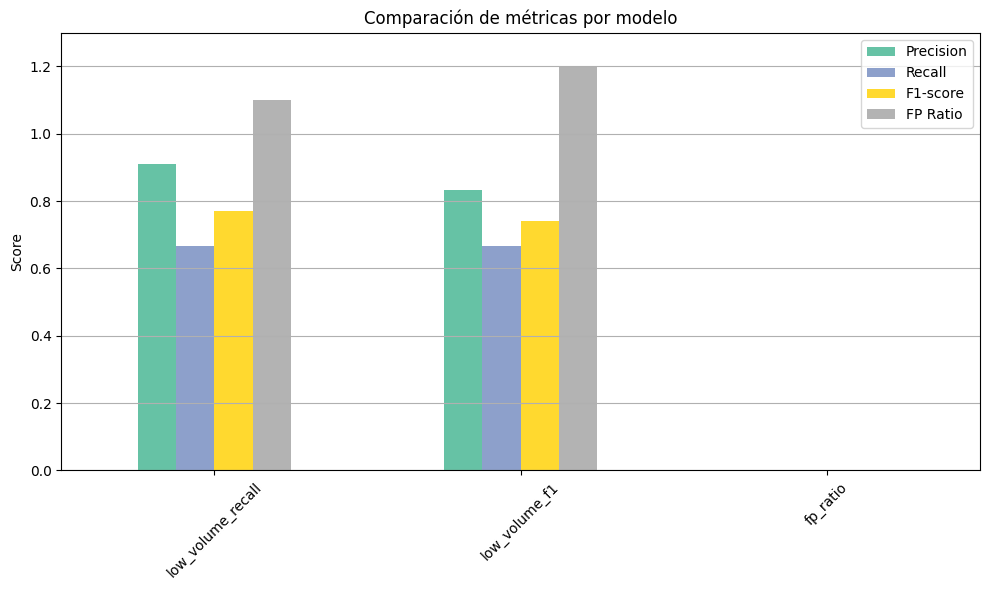

In [ ]:
# Visualización de resultados
metrics_df = test_results_df.copy()
metrics_df.plot(kind='bar', figsize=(10,6), colormap='Set2')
plt.title("Comparación de métricas por modelo")
plt.ylabel("Score")
plt.ylim(0, 1.3)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


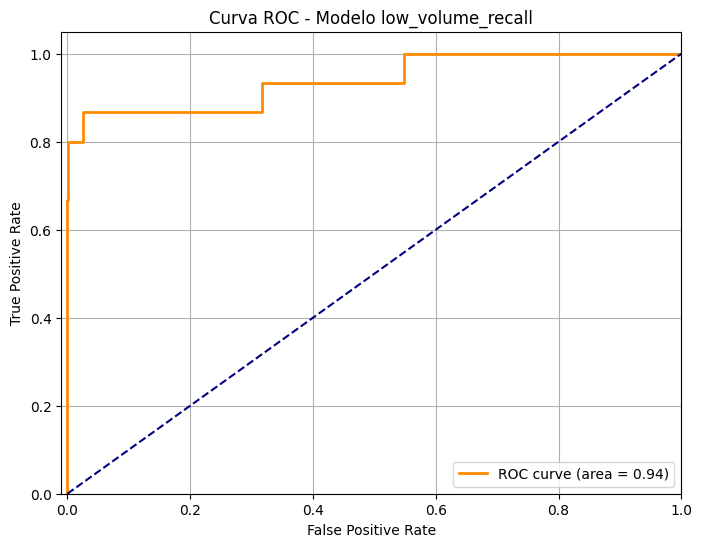

In [ ]:
# Curva ROC para el mejor modelo (low_volume_recall)
best_model = models['low_volume_recall']
y_proba = best_model.predict(X_test_imputed)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo low_volume_recall')
plt.legend(loc="lower right")
plt.grid()
plt.show()


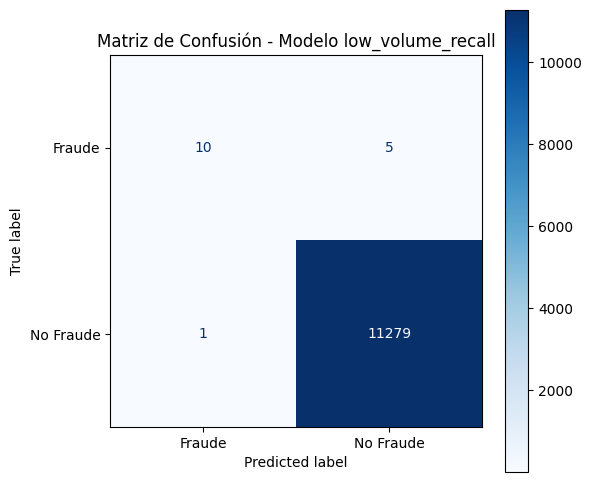

In [ ]:
y_pred = (y_proba >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fraude', 'No Fraude'])

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Matriz de Confusión - Modelo low_volume_recall')
plt.grid(False)
plt.show()


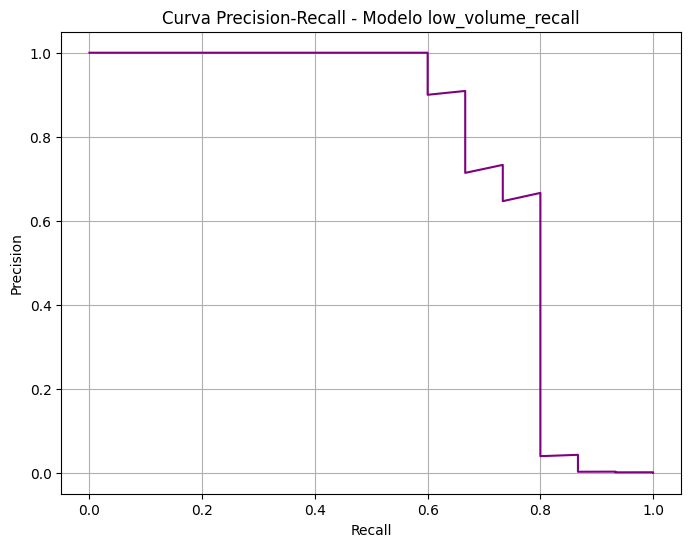

In [49]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall - Modelo low_volume_recall")
plt.grid()
plt.show()

